# QAOA in Max-Cut Formulation

### Todo
- [X] Format and standarize James's ipynb
- [X] Profit vs. P
- [X] TFQ for QAOA
- [X] TFQ Arbitrary P
- [X] Visualization. How many min vec are actually good, chance to sample min vec above a threhold profit
- [X] Sub-graph expectation/energy for p = 1 visualization & grid search optimization [Replaced by TFQ]
- [X] Sub-graph expectation/energy for p = n visualization & grid search optimization [Replaced by TFQ]
- [X] Compare QAOA simulator result with true optimality
- [ ] Compare QAOA real device result with simulator result and true optimality
- [ ] Use NX d-regular graph as the papers did
- [ ] ER Testing with probability distribution other than uniform
- [ ] Isomorphism
- [ ] Networkx for Mayizaki and CFI graph
- [ ] Disprove the D-wave isomorphism all using the counterexamples in the paper
- [ ] Why is Qiskit & TFQ yielding different results

In [3]:
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
import nlopt
import networkx as nx
import qiskit
from qiskit import BasicAer
from qiskit.optimization.ising import max_cut
from qiskit.aqua import QuantumInstance
from qiskit.aqua.components.optimizers.nlopts.esch import ESCH
from qiskit.aqua.algorithms import QAOA
from qiskit.quantum_info import Pauli
from qiskit.aqua.operators.weighted_pauli_operator import WeightedPauliOperator
import pandas as pd

from IPython.display import clear_output
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)


## Toy Example 

In [4]:
def generate_random_graph(graph_model, v_num, edges_or_prob, seed=0):
    G = graph_model(v_num, edges_or_prob, seed)
    colors = ['r' for node in G.nodes()]
    pos = nx.spring_layout(G)
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    plt.show()
    return G
def brute_optimize(v_num, adj):
    best_cost = 0
    ctr = 0
    for b in range(2**v_num):
        x = [int(t) for t in list(bin(b)[2:].zfill(v_num))]
        cost = 0
        for i in range(v_num):
            for j in range(v_num):
                ctr += 1
                cost = cost + adj[i, j]*x[i]*(1-x[j])
                update_progress(ctr / (v_num*v_num*(2**v_num)))
        if best_cost < cost:
            best_cost = cost
            x_best = x
    update_progress(1)
    print('Best solution = ' + str(x_best) + '\nBest profit = ' + str(best_cost))
    return x_best, best_cost

/Users/victorli/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


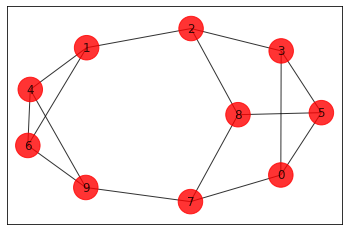

In [7]:
G_toy = generate_random_graph(nx.generators.random_graphs.random_regular_graph, 3, 10)

In [8]:
### Finding true optimality ###
adj = nx.to_numpy_matrix(G_toy)
brute_solution, best_cost = brute_optimize(len(G_toy.nodes), adj)

Progress: [####################] 100.0%
Best solution = [0, 1, 1, 0, 1, 0, 1, 0, 1, 0]
Best profit = 13.0


In [9]:
### Preparing for QAOA simulation ###
# Compute the tensor product pauli gates == (g_i tensor g_j)
def QAOA_pauli(adj):
    v_num = adj.shape[0]
    pauli_list = []
    for i in range(v_num):
        for j in range(i):
            if adj[i, j] != 0:
                # Only compute tensor product pauli gates for existing edges
                # Max-Cut formulation requires Z gates, so zero-vec X here to leave Z only
                xp = np.zeros(v_num, dtype=np.bool) 
                zp = np.zeros(v_num, dtype=np.bool)
                zp[i] = True
                zp[j] = True
                # Max-Cut formulation has a 0.5 weight (no effect on optimization)
                pauli_list.append([0.5 * adj[i, j], Pauli(zp, xp)])
    qubitOp = WeightedPauliOperator(paulis=pauli_list)
    return qubitOp

# Simulate in QAOA and retrieve approximated optimizer
def simulate_optimize(n_shots, p_steps, qubitOp, G):
    backend = BasicAer.get_backend('qasm_simulator')
    quantum_instance = QuantumInstance(backend, shots=n_shots)

    qaoa = QAOA(qubitOp, ESCH(max_evals=100), p=p_steps)
    result = qaoa.run(quantum_instance)

    # QAOA converts the problem into finding the maximum eigenval/eigenvec pair
    solution = max_cut.sample_most_likely(result['eigvecs'][0]) #returns vector with highest counts
    #print('energy:', result['energy'])
    print('solution:', solution)
    
    # For p steps, there should be 2*p parameters (beta,gamma)
    #print('optimal parameters', result['opt_params'])
    cost = 0
    for i in range(len(G.nodes)):
        for j in range(len(G.nodes)):
            cost = cost + adj[i, j]*solution[i]*(1-solution[j])
    print("Sample profit = {}".format(cost))
    
    return result, solution

In [10]:
qubitOp = QAOA_pauli(adj)
result, simulate_solution = simulate_optimize(512, 9, qubitOp, G_toy)

solution: [1 0 0 1 0 1 0 1 0 1]
Sample profit = 13.0


/Users/victorli/anaconda3/lib/python3.7/site-packages/qiskit/optimization/ising/max_cut.py:117: DeprecationWarning: sample_most_likely function has been moved to qiskit.optimization.ising.common, the method here will be removed after Aqua 0.7+
  DeprecationWarning)


In [11]:
### Compare simulation and brute optimize ###
n_shots = 512
def visualize_and_compare(brute_solution, simulate_solution, result, G, n_shots=n_shots):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    pos = nx.spring_layout(G)
    adj = nx.to_numpy_matrix(G)
    
    colors = ['r' if brute_solution[i] == 0 else 'b' for i in range(len(G.nodes))]
    nx.draw_networkx(G, ax=ax1, node_color=colors, node_size=600, alpha=.7, pos=pos)
    cost = 0
    x = brute_solution
    for i in range(len(G.nodes)):
        for j in range(len(G.nodes)):
            cost = cost + adj[i, j]*x[i]*(1-x[j])
    ax1.set_title("Brute force profit: "+str(cost))
    
    colors = ['r' if simulate_solution[i] == 0 else 'b' for i in range(len(G.nodes))]
    nx.draw_networkx(G, ax=ax2, node_color=colors, node_size=600, alpha=.7, pos=pos)
    cost = 0
    x = simulate_solution
    for i in range(len(G.nodes)):
        for j in range(len(G.nodes)):
            cost = cost + adj[i, j]*x[i]*(1-x[j])
    ax2.set_title("QAOA simulate profit: "+str(cost))
    
    plt.show()
    df = pd.DataFrame.from_dict(result['min_vector'], orient='index') / n_shots
    df = df.sort_index()
    barplot = df.plot.bar(legend=False, figsize=(10, 5), fontsize=8)
    barplot.set_xticklabels([])
    barplot.set_title("Probability of being the best in shots")

    plt.show() #as you can see, the reversed solution 011010 is the most common

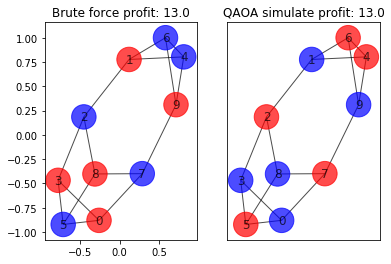

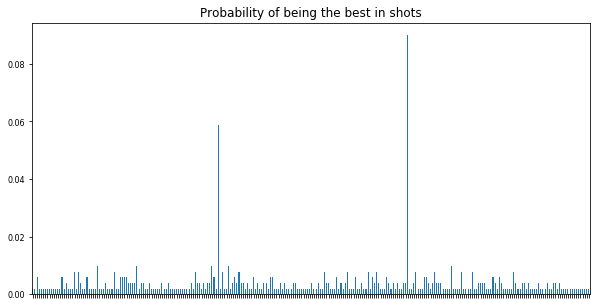

In [12]:
visualize_and_compare(brute_solution, simulate_solution, result, G_toy)

# Visulization
### Profit vs. Steps

In [5]:
p_max = 100
def pvs(v_num = 3, e_num = 10, p_max = p_max, n_shot = 512):
    G_pvs = generate_random_graph(nx.generators.random_graphs.random_regular_graph, v_num, e_num)
    adj_pvs = nx.to_numpy_matrix(G_pvs)
    brute_solution, best_profit = brute_optimize(len(G_pvs.nodes), adj_pvs)
    qubitOp_pvs = QAOA_pauli(adj_pvs)
    profits = []
    ctr = 0
    for p in range(1, p_max):
        ctr += 1
        result, simulate_solution = simulate_optimize(n_shots, p, qubitOp_pvs)
        profit = 0
        x = simulate_solution
        for i in range(len(G_pvs.nodes)):
            for j in range(len(G_pvs.nodes)):
                profit = profit + adj_pvs[i, j]*x[i]*(1-x[j])
        update_progress(ctr / (p_max - 1))
        profits.append(profit)
    return profits, best_profit

In [78]:
profits, best_profit = pvs()

Progress: [####################] 100.0%


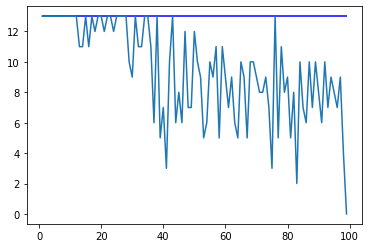

In [79]:
# Graph the profits vs. steps
fig, ax = plt.subplots()
ax.plot(range(1,p_max), profits)
ax.hlines(y=best_profit, xmin=1, xmax=p_max-1, color='b')

# TensorFlow Quantum vs. Qiskit
(Please run this at Google collab) https://colab.research.google.com/drive/19pdeY359EhTPQVHHAgmsy9fpWGRAzU5i?usp=sharing

## Observations
- TFQ Optimization is much faster than QISKIT Optimization
- TFQ Optimization has a higher average profit than QISKIT Optimization

# TensorFlow Quantum for QAOA optimization 
(Please run this at Google collab) https://colab.research.google.com/drive/1bl_mZneRUElyOHOnKRjhOk2CuQepQuWL?usp=sharing

# Visualization
### Number of solutions vs. Profit with TFQ
(Please run this at Google collab) https://colab.research.google.com/drive/1yfLdIoEFLFleCS7-8Gq_Rersr-VXg9yz?usp=sharing

This experiment is conducted so that we can get the probability of sampling a solution above a satisfying threshold